# Welly and LAS files

Some preliminaries...

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import welly
welly.__version__

'0.4.10.dev42+g3af8468.d20220207'

In [2]:
import lasio
lasio.__version__

'0.30.dev116+g87c5fda'

## Load a well from LAS

Use the `from_las()` method to load a well by passing a filename as a `str`. 

This is really just a wrapper for `lasio` but instantiates a `Header`, `Curve`s, etc.

In [3]:
from welly import Well

In [9]:
w = Well.from_las('data/P-129_out.LAS')

Only engine='normal' can read wrapped files


## Save LAS file

We can write out to LAS with a simple command, passing the file name you want:

In [10]:
w.to_las('data/out.las')

Let's just check we get the same thing out of that file as we put in:

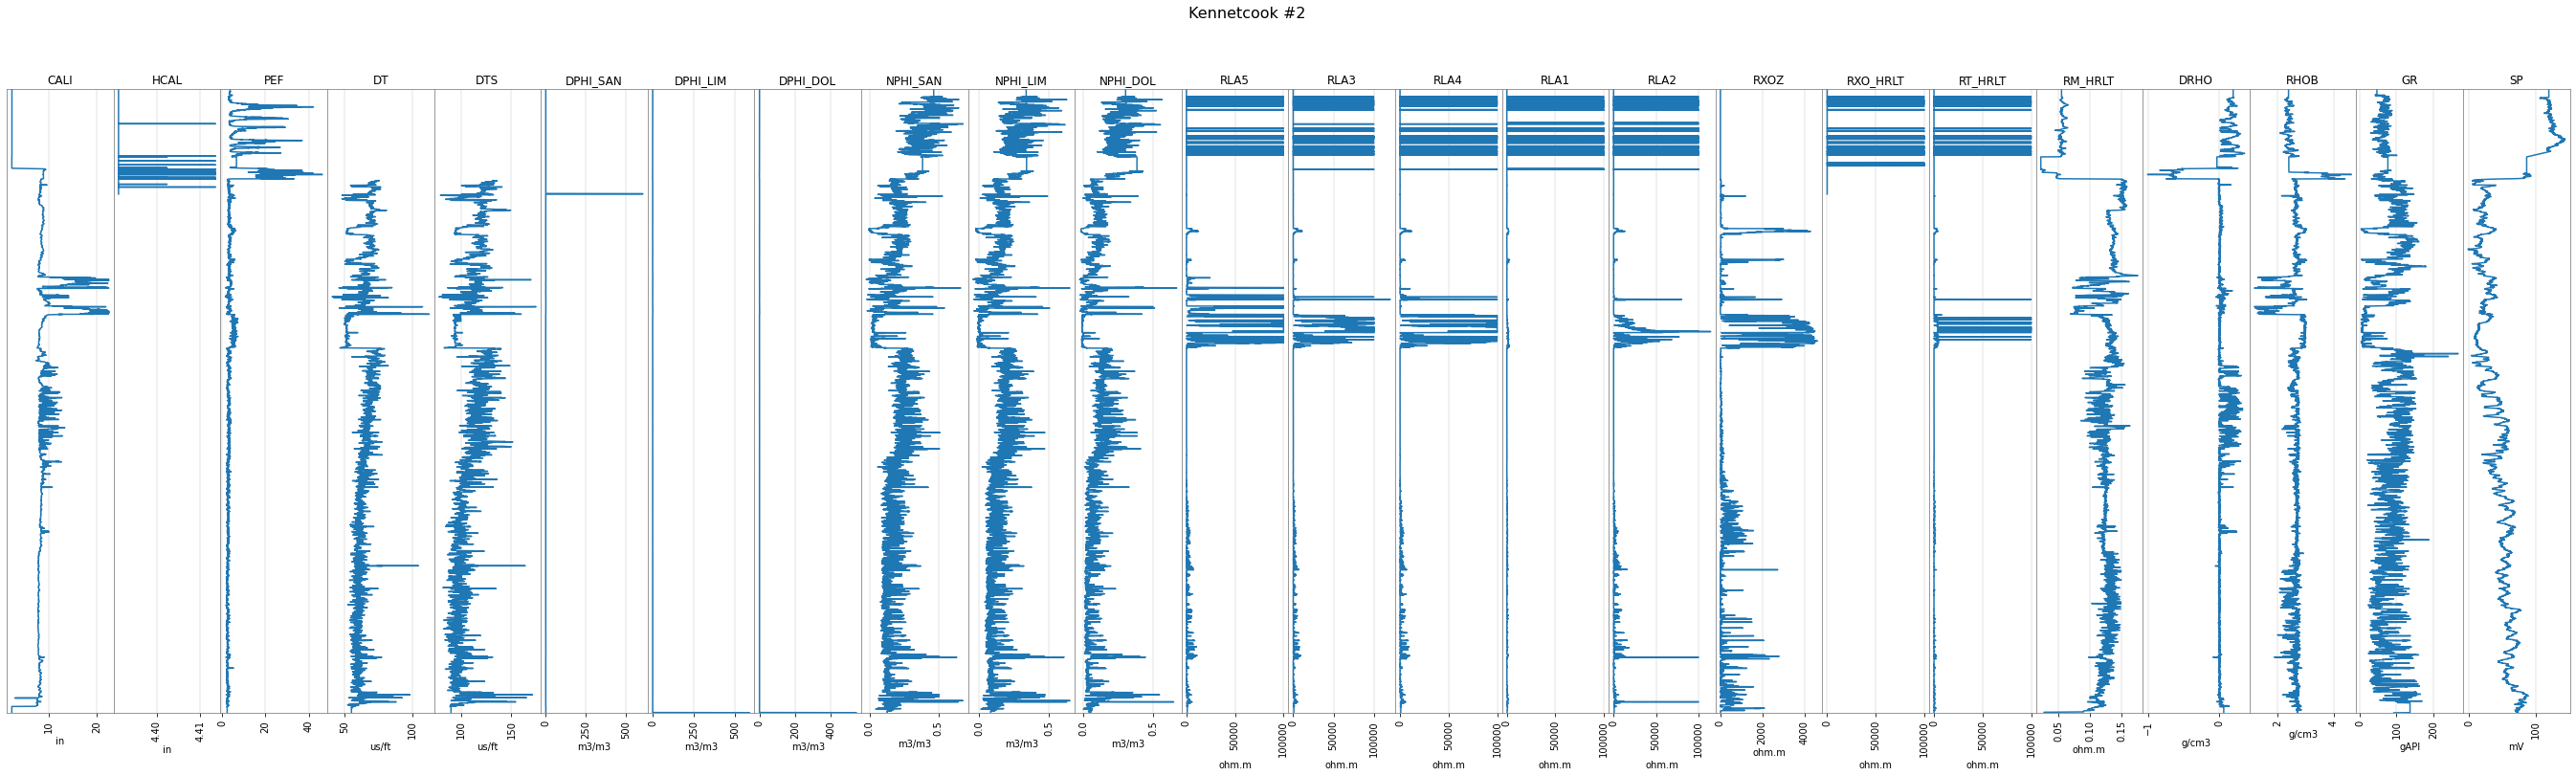

In [11]:
w.plot()

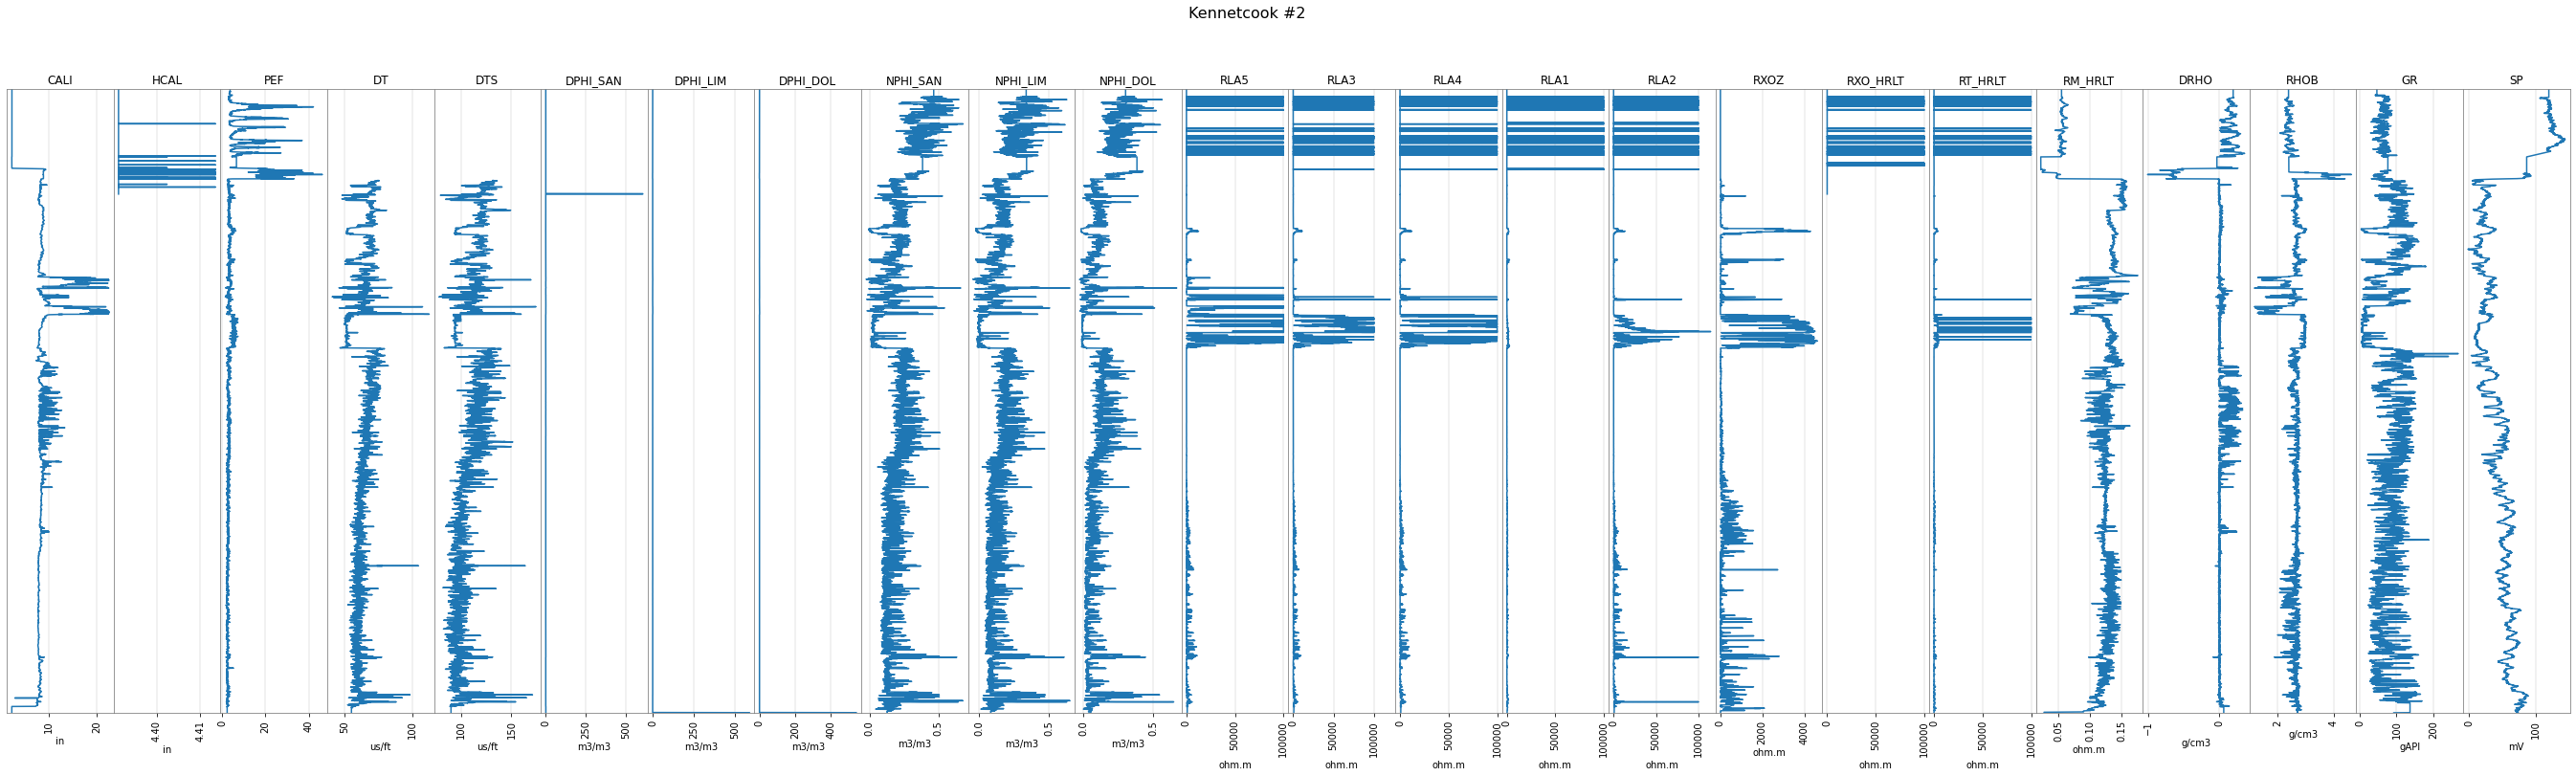

In [12]:
z = Well.from_las('data/out.las')
z.plot()

<AxesSubplot:title={'center':'CALI'}, xlabel='in'>

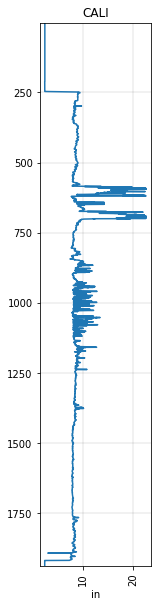

In [13]:
z.data['CALI'].plot()


We don't get the striplog back (right hand side), but everything else looks good.

## Header

Maybe should be called 'meta' as it's not really a header... 

In [14]:
w.header

,original_mnemonic,mnemonic,unit,value,descr,section
0,VERS,VERS,,2.0,,Version
1,WRAP,WRAP,,YES,,Version
2,STRT,STRT,M,1.0668,START DEPTH,Well
3,STOP,STOP,M,1939.1376,STOP DEPTH,Well
4,STEP,STEP,M,0.1524,STEP,Well
...,...,...,...,...,...,...
137,TLI,TLI,M,280.0,Top Log Interval,Parameter
138,UWID,UWID,,,Unique Well Identification Number,Parameter
139,WN,WN,,Kennetcook #2,Well Name,Parameter
140,EPD,EPD,M,90.300003,Elevation of Permanent Datum above Mean Sea Level,Parameter


In [15]:
w.header.name

AttributeError: 'DataFrame' object has no attribute 'name'

In [16]:
w.uwi

"Long = 63* 45'24.460  W"

What?? OK, we need to load this file more carefully...

## Coping with messy LAS

Some file headers are a disgrace:

    # LAS format log file from PETREL
    # Project units are specified as depth units
    #==================================================================
    ~Version information
    VERS.   2.0:
    WRAP.   YES:
    #==================================================================
    ~WELL INFORMATION
    #MNEM.UNIT      DATA             DESCRIPTION
    #---- ------ --------------   -----------------------------
    STRT .M      1.0668          :START DEPTH     
    STOP .M      1939.13760      :STOP DEPTH     
    STEP .M       0.15240        :STEP        
    NULL .          -999.25      :NULL VALUE
    COMP .        Elmworth Energy Corporation              :COMPANY
    WELL .        Kennetcook #2                            :WELL
    FLD  .        Windsor Block                            :FIELD
    LOC  .        Lat = 45* 12' 34.237" N                  :LOCATION
    PROV .        Nova Scotia                              :PROVINCE
      UWI.        Long = 63* 45'24.460  W                  :UNIQUE WELL ID
    LIC  .        P-129                                    :LICENSE NUMBER
    CTRY .        CA                                       :COUNTRY (WWW code)
     DATE.        10-Oct-2007                              :LOG DATE {DD-MMM-YYYY}
    SRVC .        Schlumberger                             :SERVICE COMPANY
    LATI .DEG                                              :LATITUDE
    LONG .DEG                                              :LONGITUDE
    GDAT .                                                 :GeoDetic Datum
    SECT .        45.20 Deg N                              :Section
    RANG .        PD 176                                   :Range
    TOWN .        63.75 Deg W                              :Township

In [17]:
import welly
import re

def transform_ll(text):
    def callback(match):
        d = match.group(1).strip()
        m = match.group(2).strip()
        s = match.group(3).strip()
        c = match.group(4).strip()
        if c.lower() in ('w', 's') and d[0] != '-':
            d = '-' + d
        return ' '.join([d, m, s])
    pattern = re.compile(r""".+?([-0-9]+?).? ?([0-9]+?).? ?([\.0-9]+?).? +?([NESW])""", re.I)
    text = pattern.sub(callback, text)
    return welly.utils.dms2dd([float(i) for i in text.split()])

In [18]:
print(transform_ll("""Lat = 45* 12' 34.237" N"""))
print(transform_ll("""Long = 63* 45'24.460  W"""))

45.20951027777778
-62.243205555555555


In [19]:
remap = {
    'LATI': 'LOC',  # Use LOC for the parameter LATI.
    'LONG': 'UWI',  # Use UWI for the parameter LONG.
    'SECT': None,   # Use nothing for the parameter SECT.
    'RANG': None,   # Use nothing for the parameter RANG.
    'TOWN': None,   # Use nothing for the parameter TOWN.
}

funcs = {
    'LATI': transform_ll,  # Pass LATI through this function before loading.
    'LONG': transform_ll,  # Pass LONG through it too.
    'UWI': lambda x: "No name, oh no!"
}

In [20]:
w = Well.from_las('data/P-129_out.LAS', remap=remap, funcs=funcs)

Only engine='normal' can read wrapped files


In [21]:
w.location

Location({'position': None, 'crs': CRS({}), 'location': 'Lat = 45* 12\' 34.237" N', 'country': 'CA', 'province': 'Nova Scotia', 'latitude': 45.20951027777778, 'longitude': -62.243205555555555, 'datum': '', 'ekb': 94.8, 'egl': 90.3, 'gl': 90.3, 'tdd': 1935.0, 'tdl': 1935.0, 'td': None, 'deviation': None})

In [22]:
w.location.crs  # Should be empty.

CRS({})

In [23]:
w.uwi

'No name, oh no!'

---

&copy; 2022 Agile Scientific, CC BY